In [52]:
#!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.0/30.0 MB 2.9 MB/s eta 0:00:0000:0100:01


In [2]:
import os
import io
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from hashlib import blake2b
from matplotlib import pyplot
from math import sin, cos, pi

# standard
import pandas as pd
import numpy as np
import random

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import models
from keras import layers

# plots
import seaborn as sns

# OpenCV for s a library containing programming functions
# mainly aimed at real-time computer vision problem solving
import cv2


## Load data

In [4]:
# load dataset
train_data = '../facial-keypoints-detection/data/training.csv'
test_data = '../facial-keypoints-detection/data/test.csv'
df_train = pd.read_csv(train_data)
df_test = pd.read_csv(test_data)
print('Labeled image records: ', len(df_train))
print('Kaggle test image records: ', len(df_test))
print('First few image records: ')
display(df_train.head(5))

Labeled image records:  7049
Kaggle test image records:  1783
First few image records: 


,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


In [5]:
print(df_train.shape, df_test.shape)

(7049, 31) (1783, 2)


In [6]:
# The Image column has pixel values separated by space; convert to numpy arrays:
df_train['Image'] = df_train['Image'].apply(lambda im: np.fromstring(im, sep=' '))

## Missing values

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

In [8]:
print(df_train.isnull().sum())
print("-"*50)
print(df_test.isnull().sum())

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

### what to do with missing values? (images without keypoints coordinates for some of the keypoints). 
Whatever we do, would be the same in the test dataset.
Options:
- not use them
- impute a 0

In [9]:
#df_train['left_eye_center_x'].fillna(0, inplace=True)

# for left_eye (10 missing values), we drop rows with missing values
df_train = df_train.dropna()

In [10]:
# we are left with 2140 records
print(df_train.count())

left_eye_center_x            2140
left_eye_center_y            2140
right_eye_center_x           2140
right_eye_center_y           2140
left_eye_inner_corner_x      2140
left_eye_inner_corner_y      2140
left_eye_outer_corner_x      2140
left_eye_outer_corner_y      2140
right_eye_inner_corner_x     2140
right_eye_inner_corner_y     2140
right_eye_outer_corner_x     2140
right_eye_outer_corner_y     2140
left_eyebrow_inner_end_x     2140
left_eyebrow_inner_end_y     2140
left_eyebrow_outer_end_x     2140
left_eyebrow_outer_end_y     2140
right_eyebrow_inner_end_x    2140
right_eyebrow_inner_end_y    2140
right_eyebrow_outer_end_x    2140
right_eyebrow_outer_end_y    2140
nose_tip_x                   2140
nose_tip_y                   2140
mouth_left_corner_x          2140
mouth_left_corner_y          2140
mouth_right_corner_x         2140
mouth_right_corner_y         2140
mouth_center_top_lip_x       2140
mouth_center_top_lip_y       2140
mouth_center_bottom_lip_x    2140
mouth_center_b

### Split train/dev

In [11]:
# 80% training, 20% dev (for test, submit test data to Kaggle)
df_train_2 = df_train.sample(frac = 0.8, random_state=1)
# the remaining 20% we need to split half and half for dev and test
df_dev = df_train.drop(df_train_2.index)

print(df_train_2.shape)
print(df_dev.shape)


(1712, 31)
(428, 31)


### Preprocess pixels and coordinates

In [12]:
# scale pixel values to [0,1]
trainX = np.vstack(df_train_2['Image'].values) / 255
trainX = trainX.astype(np.float32)
trainX = trainX.reshape(-1,96,96,1)

devX = np.vstack(df_dev['Image'].values) / 255
devX = devX.astype(np.float32)
devX = devX.reshape(-1,96,96,1)




In [13]:
trainY = df_train_2[df_train_2.columns[:-1]].values

devY = df_dev[df_dev.columns[:-1]].values


In [14]:
print("trainX.shape == {}; trainX.min == {:.3f}; trainX.max == {:.3f}".format(
    trainX.shape, trainX.min(), trainX.max()))
print("devX.shape == {}; devX.min == {:.3f}; devX.max == {:.3f}".format(
    devX.shape, devX.min(), devX.max()))


print("trainY.shape == {}; trainY.min == {:.3f}; trainY.max == {:.3f}".format(
    trainY.shape, trainY.min(), trainY.max()))
print("devY.shape == {}; devY.min == {:.3f}; devY.max == {:.3f}".format(
    devY.shape, devY.min(), devY.max()))


trainX.shape == (1712, 96, 96, 1); trainX.min == 0.000; trainX.max == 1.000
devX.shape == (428, 96, 96, 1); devX.min == 0.000; devX.max == 1.000
trainY.shape == (1712, 30); trainY.min == 3.826; trainY.max == 95.809
devY.shape == (428, 30); devY.min == 7.621; devY.max == 94.674


## Plot some images

In [15]:
def plot_images(images, points, ncols, shrinkage=0.2):
  """
  Function to plot images and their lables:
  INPUT:
      images: numpy array with shape (N, d, d, c) dtype=float
      points: numpy array with shape (N,), dtype=float
      ncols: number of columns in the resulting image grid
      shrinage: how much each image to be shrinked for display
  """
  
  nindex, height, width, intensity = images.shape
  nrows = nindex//ncols
  print(f"Number of rows: {nrows}, number of cols: {ncols}")
  
  fig_width = int(width*ncols*shrinkage)
  fig_height = int(height*nrows*shrinkage)

  fig, axes = plt.subplots(nrows, ncols, 
                          figsize=(fig_width, fig_height))
  print(f"Figure width: {fig_width}, height: {fig_height}")
  axes = axes.flatten()
  
  for k in range(nindex):
    img = images[k]
    img = tf.keras.utils.array_to_img(img)
    ax = axes[k]
    ax.imshow(img, cmap="Greys_r")
    pnt_x = [points[k][2*j] for j in range(15)]
    pnt_y = [points[k][2*j+1] for j in range(15)]
    ax.scatter(pnt_x,pnt_y,s=50,c='r')
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

Number of rows: 2, number of cols: 6
Figure width: 57, height: 19


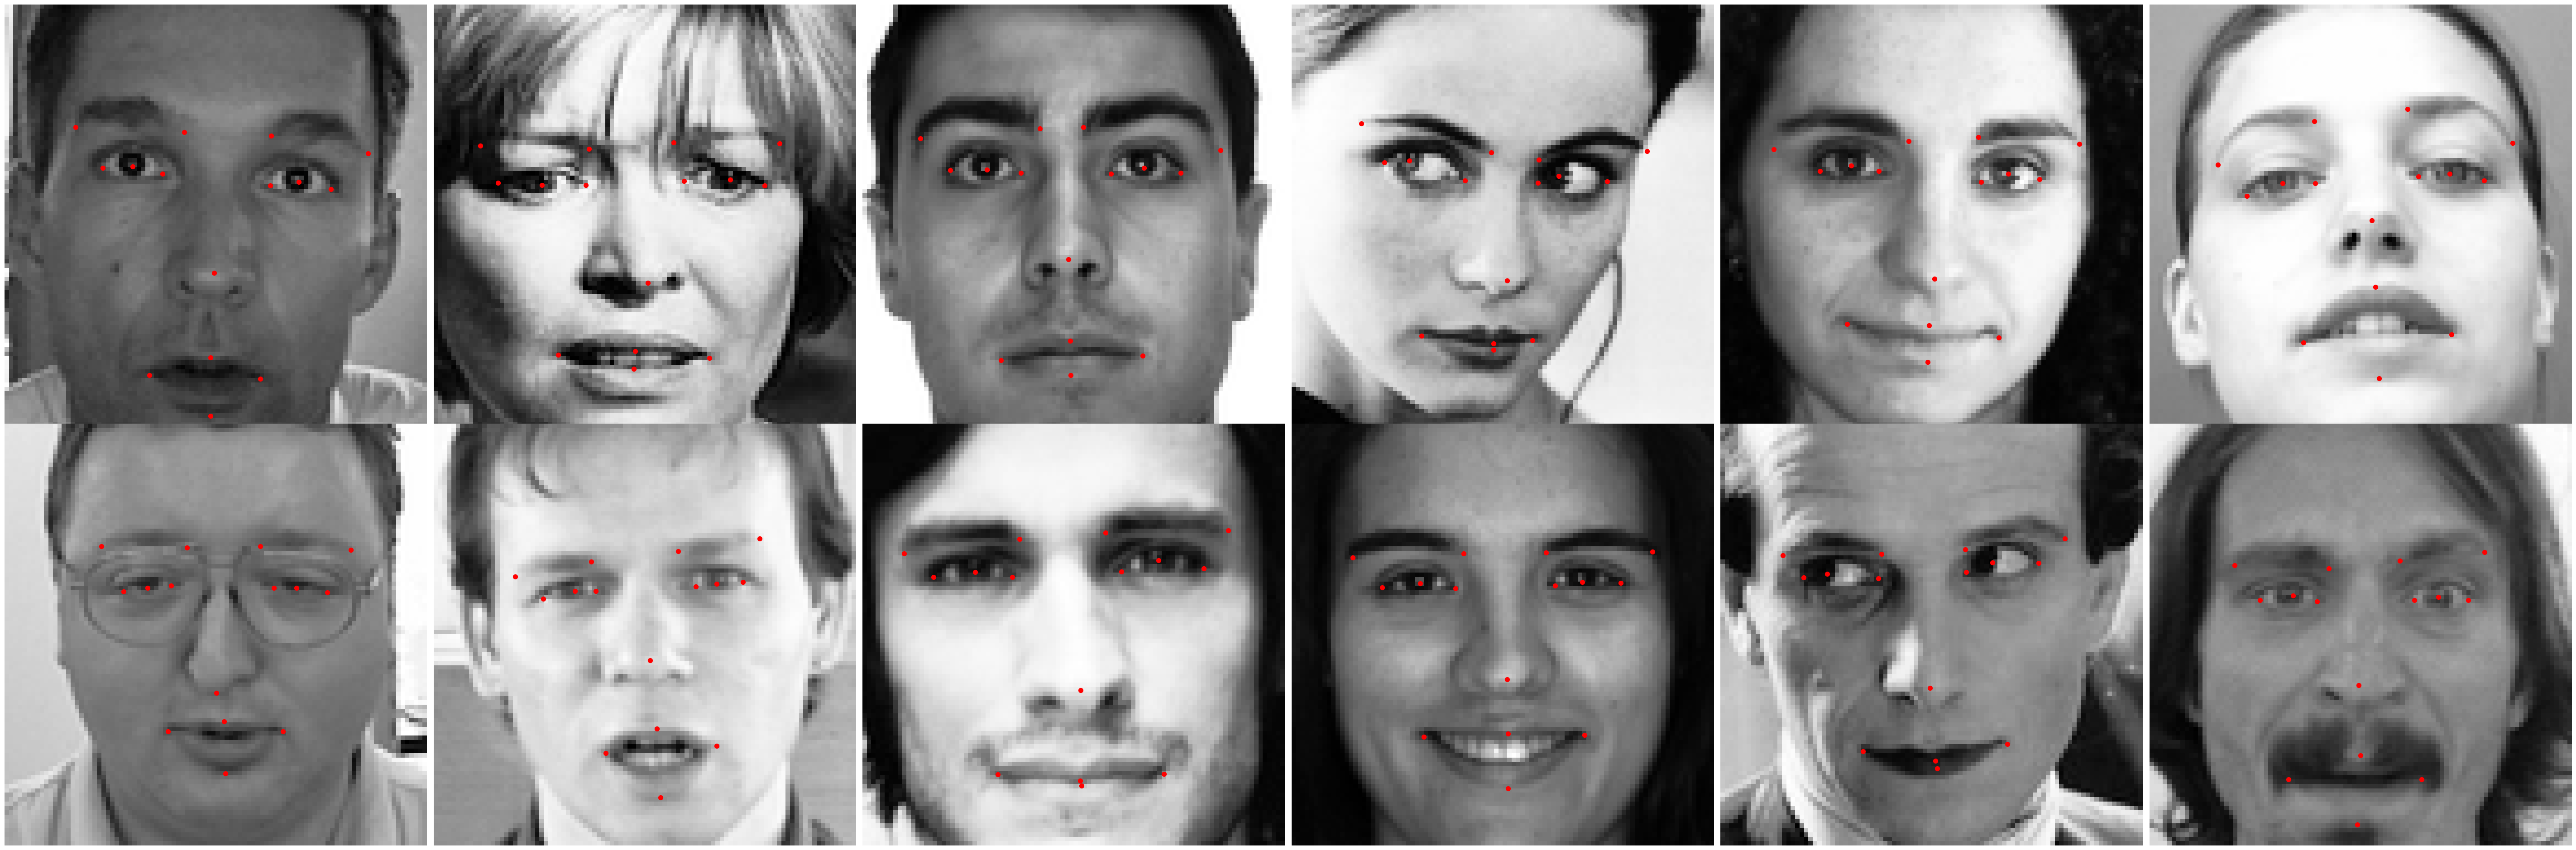

In [16]:
plot_images(trainX[:12], trainY[:12], 6, shrinkage=0.1)

## Baseline cnn model

In [17]:


random.seed(2)
%matplotlib inline

# from keras.models import Sequential, Model
# from keras.layers import Activation, Convolution2D,MaxPooling2D,BatchNormalization, Flatten, Dense, Dropout


### Build model

In [18]:
model = tf.keras.Sequential()

# add first convolution layer to the model
model.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))


# add a max pooling layer with pool size (2,2) and strides of 2
# (this will reduce the spatial dimensions by half)
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    name='pool_1'))


# add second convolutional layer
model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(2, 2),
    strides=(1, 1),
    padding='same',
    name='conv_2',
    activation='relu'))

# add second max pooling layer with pool size (2,2) and strides of 2
# (this will further reduce the spatial dimensions by half)
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_2')
)

# add third convolutional layer
model.add(tf.keras.layers.Conv2D(
    filters=128,
    kernel_size=(2, 2),
    strides=(1, 1),
    padding='same',
    name='conv_3',
    activation='relu'))

# add second max pooling layer with pool size (2,2) and strides of 2
# (this will further reduce the spatial dimensions by half)
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_3')
)

# add a fully connected layer (need to flatten the output of the previous layers first)
model.add(tf.keras.layers.Flatten()) 
model.add(tf.keras.layers.Dense(
    units=1024,
    name='fc_1', 
    activation='relu'))

# add dropout layer
model.add(tf.keras.layers.Dropout(
    rate=0.5))

# add the last fully connected layer
# this last layer sets the activation function to "None" in order to output the logits 
# note that passing activation = "sigmoid" will return class memembership probabilities but
# in TensorFlow logits are prefered for numerical stability
# set units=2 to get two output unit (coordinates for one keypoint)
model.add(tf.keras.layers.Dense(
    units=30,
    name='fc_2',
    activation=None))


# build model and print summary
tf.random.set_seed(1)
model.build(input_shape=(None, 96, 96,1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 96, 96, 32)        320       
                                                                 
 pool_1 (MaxPooling2D)       (None, 48, 48, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 48, 48, 64)        8256      
                                                                 
 pool_2 (MaxPooling2D)       (None, 24, 24, 64)        0         
                                                                 
 conv_3 (Conv2D)             (None, 24, 24, 128)       32896     
                                                                 
 pool_3 (MaxPooling2D)       (None, 12, 12, 128)       0         
                                                                 
 flatten (Flatten)           (None, 18432)             0

### Compile Model
We have to decide on the type of optimizer, loss function, and metrics to compute.

We will use the Adam optimizer for this assignment, the most popular gradient-based optimization algorithm. 

The loss (cost) function is RMSE, which is the evaluation metric for the Kaggle competition.

We will compute model accuracy on the training, validation and test datasets.

In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.MeanSquaredError()) 


### Fit Model

In [20]:

tf.random.set_seed(1234)
np.random.seed(1234)
history = model.fit(trainX, trainY,
                    epochs=20, 
                    validation_data=(devX, devY)
)

Epoch 1/20
54/54 [==============================] - 10s 178ms/step - loss: 411.9798 - val_loss: 27.3454
Epoch 2/20
54/54 [==============================] - 10s 178ms/step - loss: 61.3158 - val_loss: 13.6877
Epoch 3/20
54/54 [==============================] - 10s 179ms/step - loss: 44.9993 - val_loss: 12.8552
Epoch 4/20
54/54 [==============================] - 10s 180ms/step - loss: 35.6190 - val_loss: 11.3766
Epoch 5/20
54/54 [==============================] - 10s 179ms/step - loss: 31.9267 - val_loss: 9.8190
Epoch 6/20
54/54 [==============================] - 10s 179ms/step - loss: 28.9204 - val_loss: 17.4999
Epoch 7/20
54/54 [==============================] - 10s 183ms/step - loss: 28.3544 - val_loss: 20.3002
Epoch 8/20
54/54 [==============================] - 10s 182ms/step - loss: 26.8978 - val_loss: 8.6188
Epoch 9/20
54/54 [==============================] - 10s 184ms/step - loss: 23.1772 - val_loss: 9.0542
Epoch 10/20
54/54 [==============================] - 10s 184ms/step - loss:

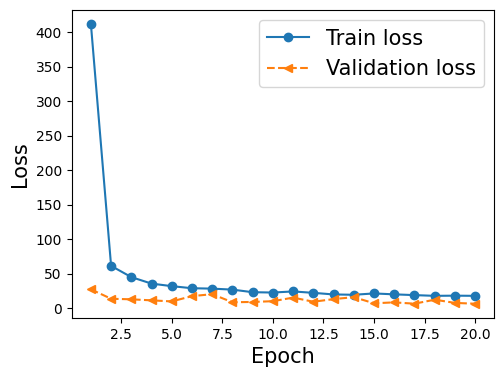

In [21]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

plt.show()

In [22]:
# compare to Kaggle competition benchmark (with validation set)
# RMSE
np.sqrt(4.99)

2.233830790368868

In [23]:
model.evaluate(devX[:2],devY[:2])

1/1 [==============================] - 0s 24ms/step - loss: 2.6046


2.6046416759490967

In [24]:
devX[:2].shape

(2, 96, 96, 1)

In [28]:
model.predict(devX[:2]).shape

1/1 [==============================] - 0s 22ms/step


(2, 30)

## See predicted and labelled images

1/1 [==============================] - 0s 23ms/step
Number of rows: 1, number of cols: 3
Figure width: 28, height: 9


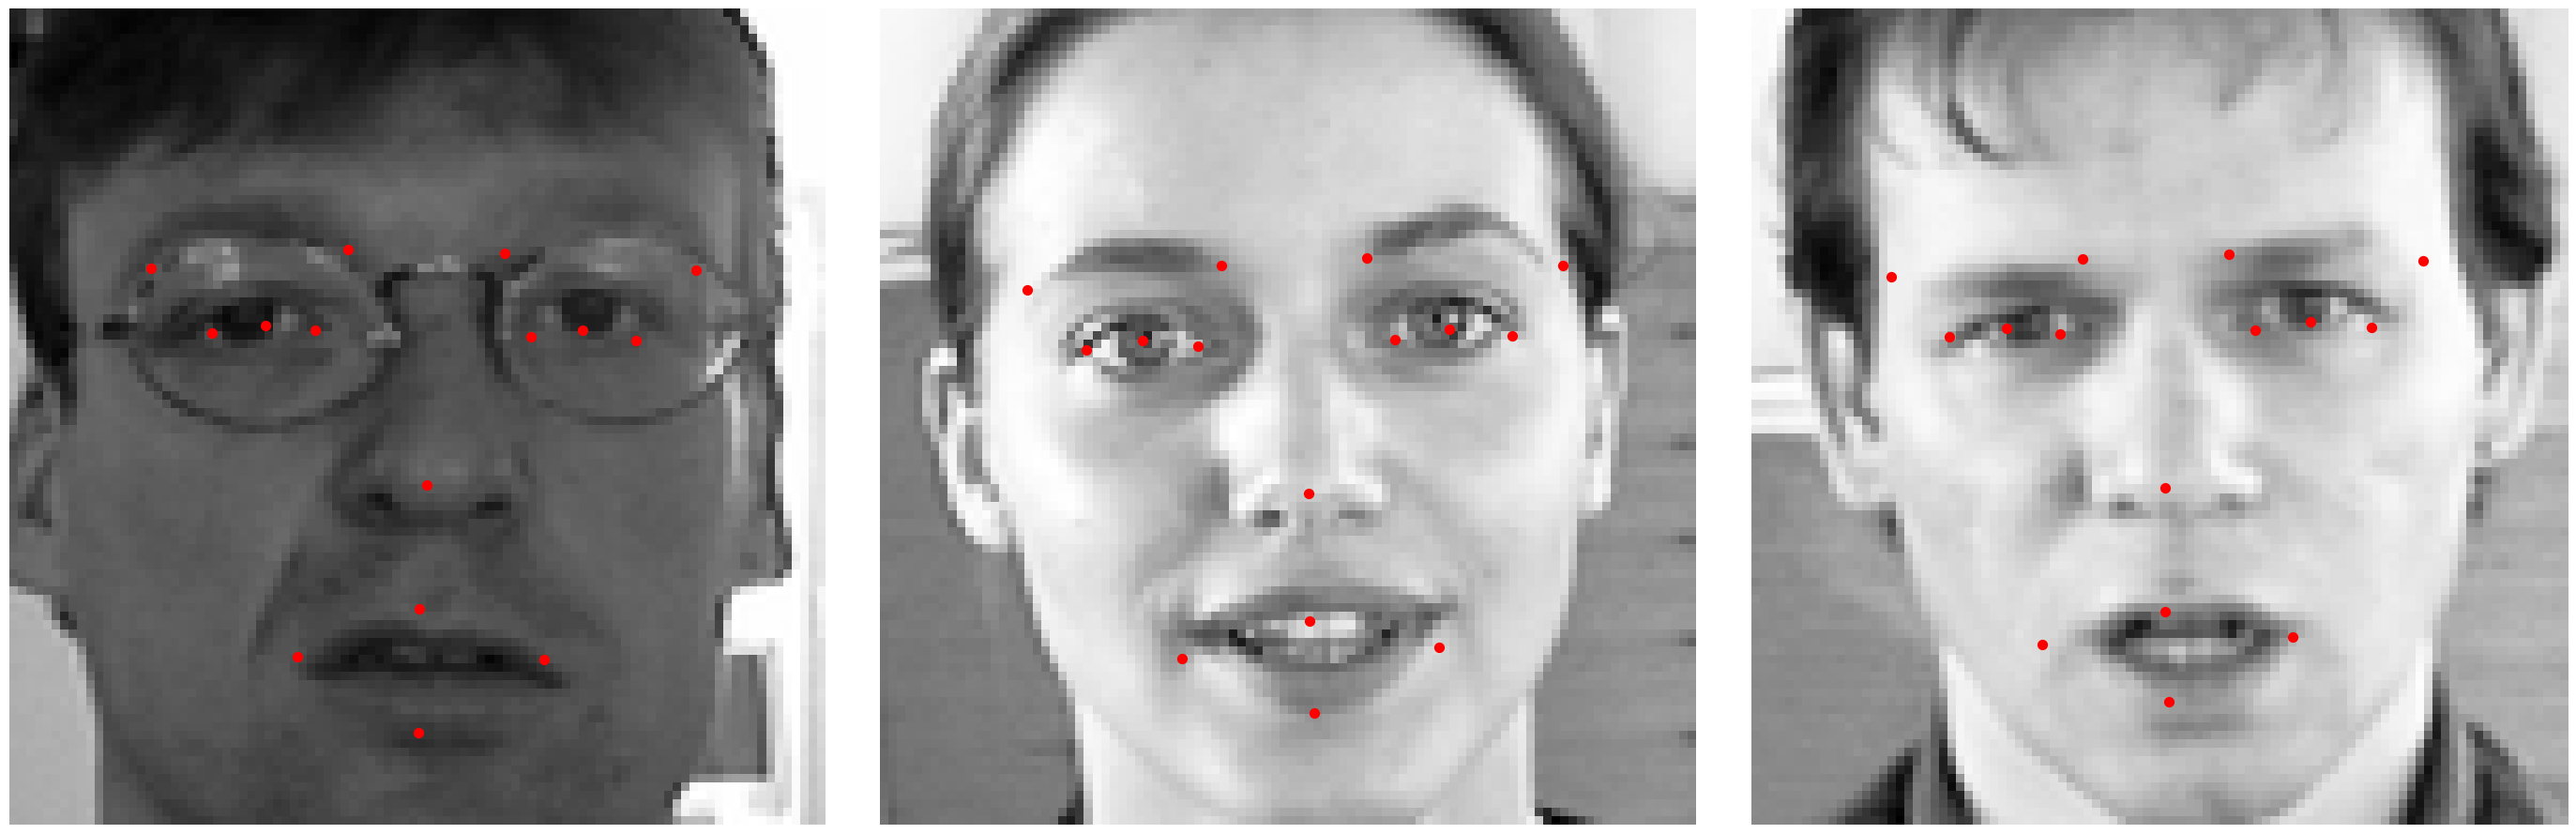

In [29]:
# predicted
plot_images(devX[:3], model.predict(devX[:3]), 3, shrinkage=0.1)

Number of rows: 1, number of cols: 3
Figure width: 28, height: 9


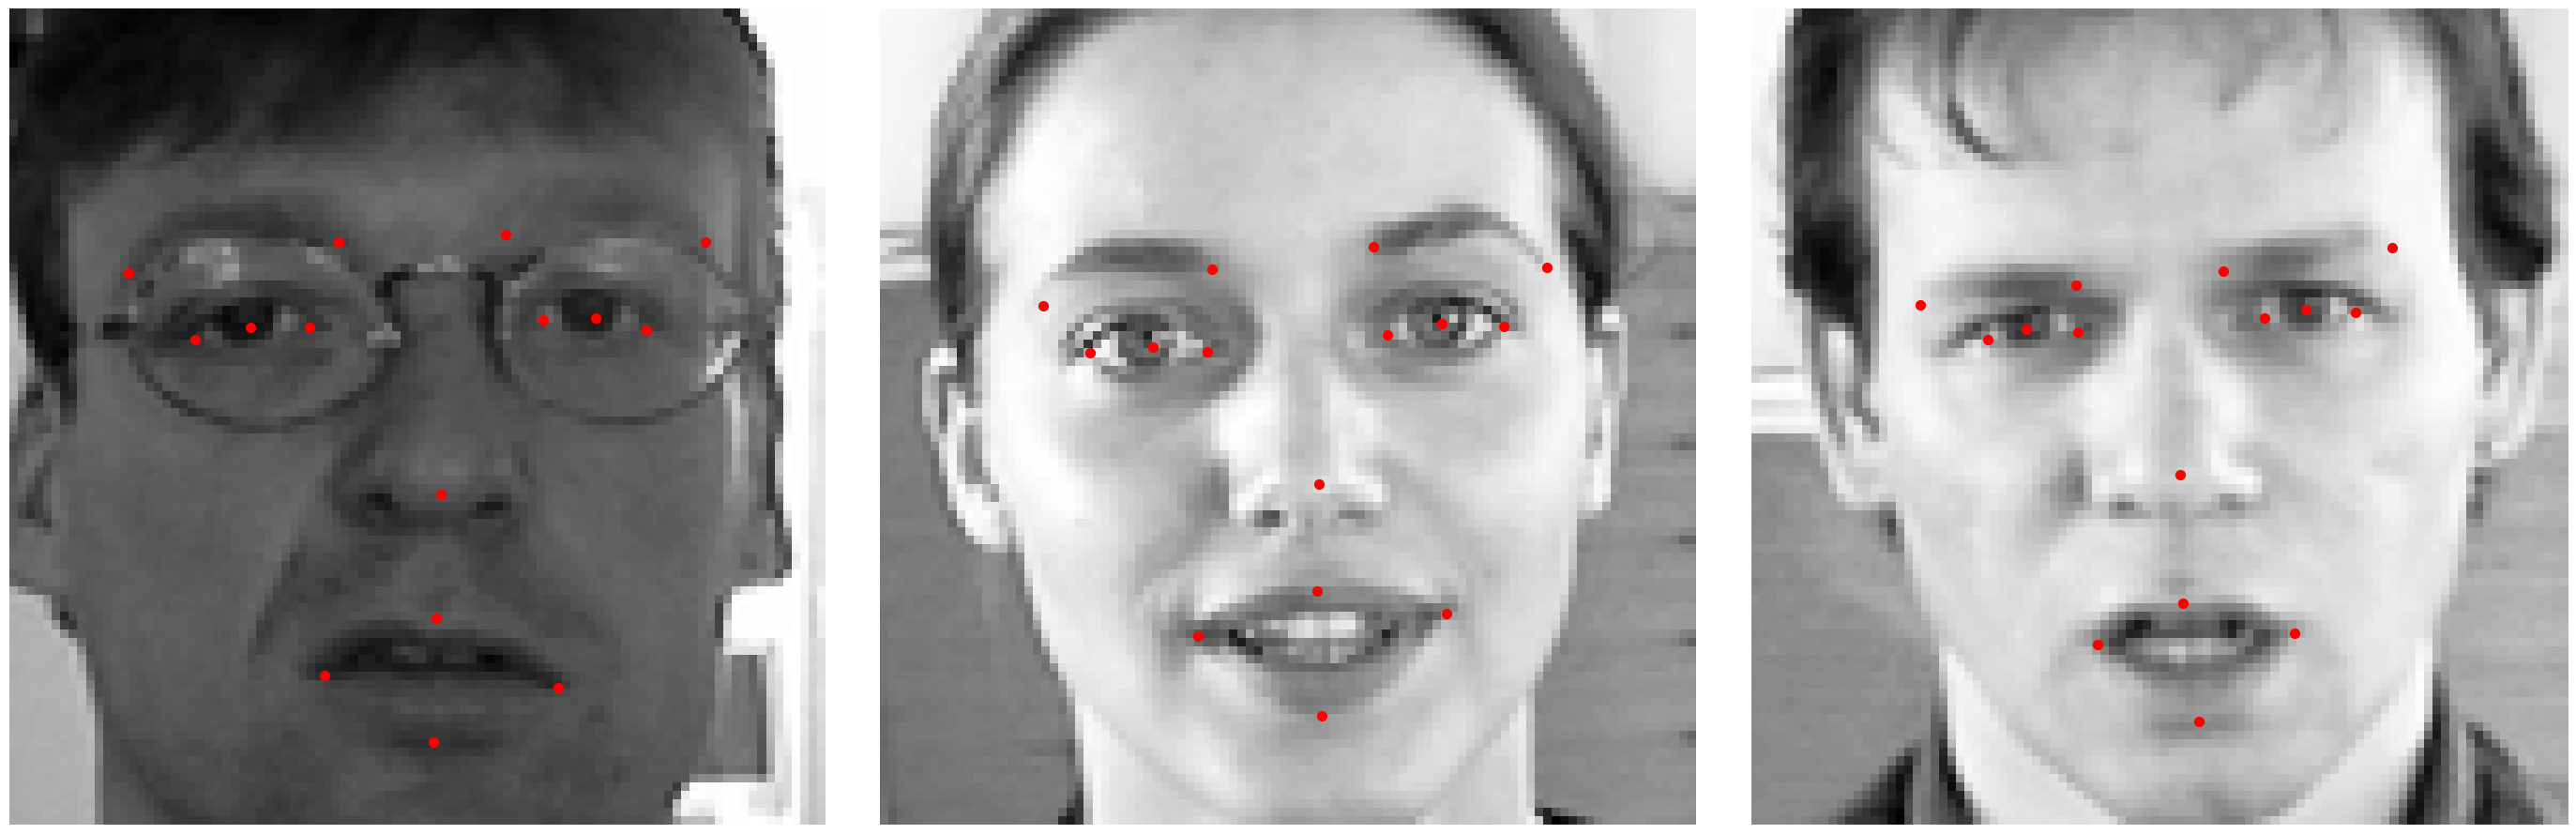

In [30]:
# labelled
plot_images(devX[:3], devY[:3], 3, shrinkage=0.1)

Number of rows: 2, number of cols: 6
Figure width: 57, height: 19


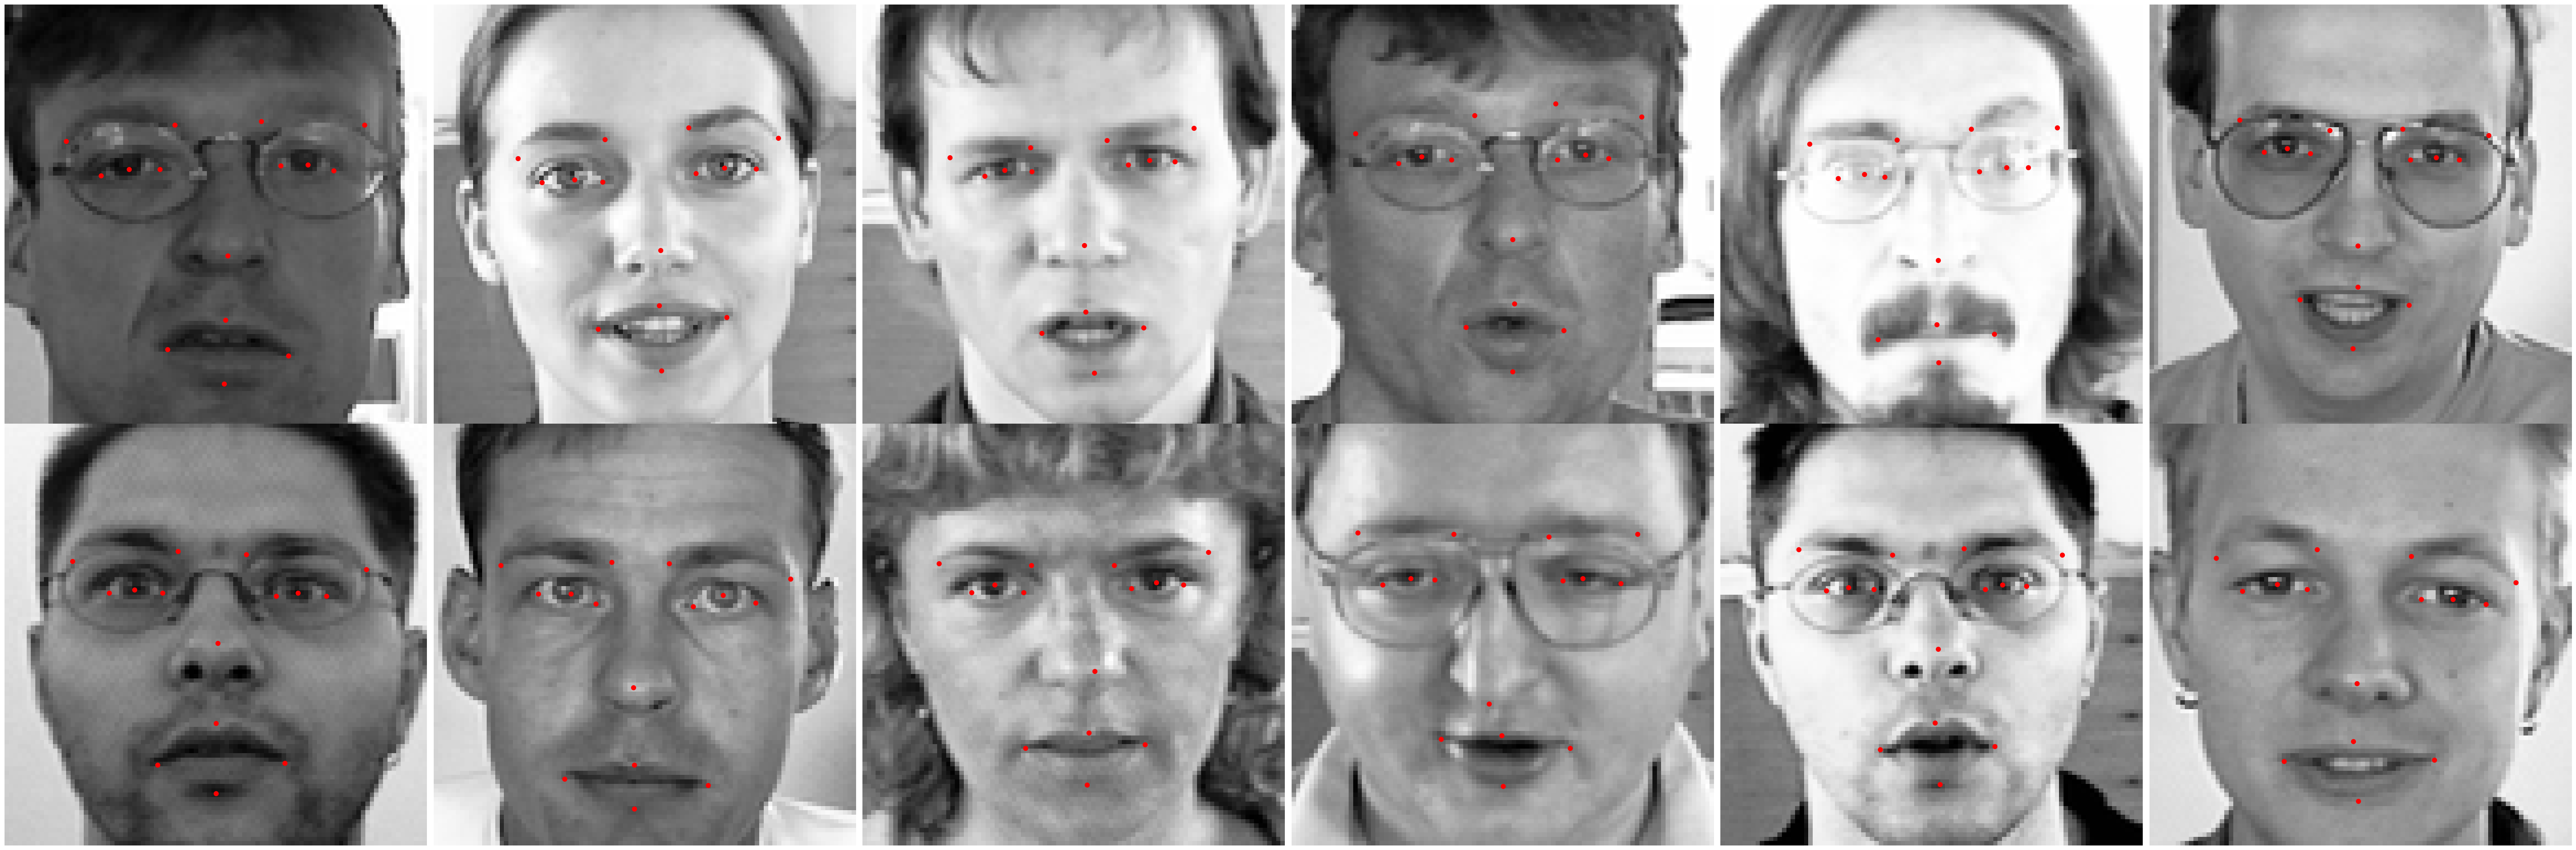

In [31]:
plot_images(devX[:12], devY[:12], 6, shrinkage=0.1)

## Augmentation

### Helper functions

In [32]:
def aug_rotation(X, y, rotation_angles=[15]):
    """
    Function to rotate images (X) and points (y) in the same time.
    INPUT:
        X: numpy array with shape (n, d, d, c)
        y: points to plot with shape (n, m)
        rotation_angles: a list of angles to rotate
    OUTPUT:
        augmented images with shape (n, d, d, c)
        augmented points with shape (n, m)

    """

    rotated_images = []
    rotated_keypoints = []
    
    size = X.shape[1] # suppose h == w
    
    center = (int(size/2), int(size/2))
    
    for angle in rotation_angles:
        for angle in [angle, -angle]:
            rot = cv2.getRotationMatrix2D(center, angle, 1.)
            angle_rad = -angle*pi/180.
            
            for image in X:
                rotated_image = cv2.warpAffine(image.reshape(size,size), rot, (size, size), flags=cv2.INTER_CUBIC)
                rotated_images.append(rotated_image)
                
            for keypoint in y:
                rotated_keypoint = keypoint - int(size/2)
                
                for idx in range(0, len(rotated_keypoint), 2):
                    rotated_keypoint[idx] = rotated_keypoint[idx]*cos(angle_rad)-rotated_keypoint[idx+1]*sin(angle_rad)
                    rotated_keypoint[idx+1] = rotated_keypoint[idx]*sin(angle_rad)+rotated_keypoint[idx+1]*cos(angle_rad)
                rotated_keypoint += size/2   
                rotated_keypoints.append(rotated_keypoint)
    
    return np.reshape(rotated_images,(-1,size,size,1)), np.array(rotated_keypoints)

In [33]:
def aug_shift(X, y, pixel_shifts=[15]):
    """
    Function to shift images (X) and points (y) in the same time.
    INPUT:
        X: numpy array with shape (n, d, d, c)
        y: points to plot with shape (n, m)
        pixel_shifts: a list of values indicating horizontal & vertical shift amount in pixels
    OUTPUT:
        augmented images with shape (n, d, d, c)
        augmented points with shape (n, m)
    """
    size = X.shape[1]
    shifted_images = []
    shifted_keypoints = []
    for shift in pixel_shifts:    
        for (shift_x,shift_y) in [(-shift,-shift),(-shift,shift),(shift,-shift),(shift,shift)]:
            sh = np.float32([[1,0,shift_x],[0,1,shift_y]])
            
            for image, keypoint in zip(X, y):
                shifted_image = cv2.warpAffine(image, sh, (size,size), flags=cv2.INTER_CUBIC)
                shifted_keypoint = np.array([(point+shift_x) if idx%2==0 else (point+shift_y) for idx, point in enumerate(keypoint)])
                
                if np.all(0.0<shifted_keypoint) and np.all(shifted_keypoint<size):
                    shifted_images.append(shifted_image.reshape(size,size,1))
                    shifted_keypoints.append(shifted_keypoint)
    shifted_keypoints = np.clip(shifted_keypoints,0.0,size)
    return np.array(shifted_images), np.array(shifted_keypoints)

In [34]:
def aug_brightness(X, y, brightness_range=[0.6,1.2]):
    """
    Function to adjust the brightness of images (X) 
    INPUT:
        X: numpy array with shape (n, d, d, c)
        y: points to plot with shape (n, m)
        brightness_range: a list of two values to decrease/increase brightness
    OUTPUT:
        augmented images with shape (n, d, d, c)
        augmented points with shape (n, m)
    Note:
        Brightness is pre-defined as either 1.2 times or 0.6 times
    """
    altered_brightness_images = []
    inc_brightness_images = np.clip(X*brightness_range[1], 0, 255)    
    dec_brightness_images = np.clip(X*brightness_range[0], 0, 255)    
    altered_brightness_images.extend(inc_brightness_images)
    altered_brightness_images.extend(dec_brightness_images)
    return np.array(altered_brightness_images), np.concatenate((y, y))

In [35]:
def aug_noise(X, y, noise=0.008):
    """
    Function to add noises images (X) 
    INPUT:
        X: numpy array with shape (n, d, d, c)
        y: points to plot with shape (n, m)
        noise: a value times a random number of normal distribution as noise impact
    OUTPUT:
        augmented images with shape (n, d, d, c)
        augmented points with shape (n, m)
    """
    noisy_images = []
    size = X.shape[1]
    for image in X:
        noisy_image = cv2.add(image, noise*np.random.randn(size,size,1))    
        noisy_images.append(noisy_image.reshape(size,size,1))
    return np.array(noisy_images), y

### Apply augmentation functions

(3424, 96, 96, 1)
Number of rows: 2, number of cols: 6
Figure width: 57, height: 19


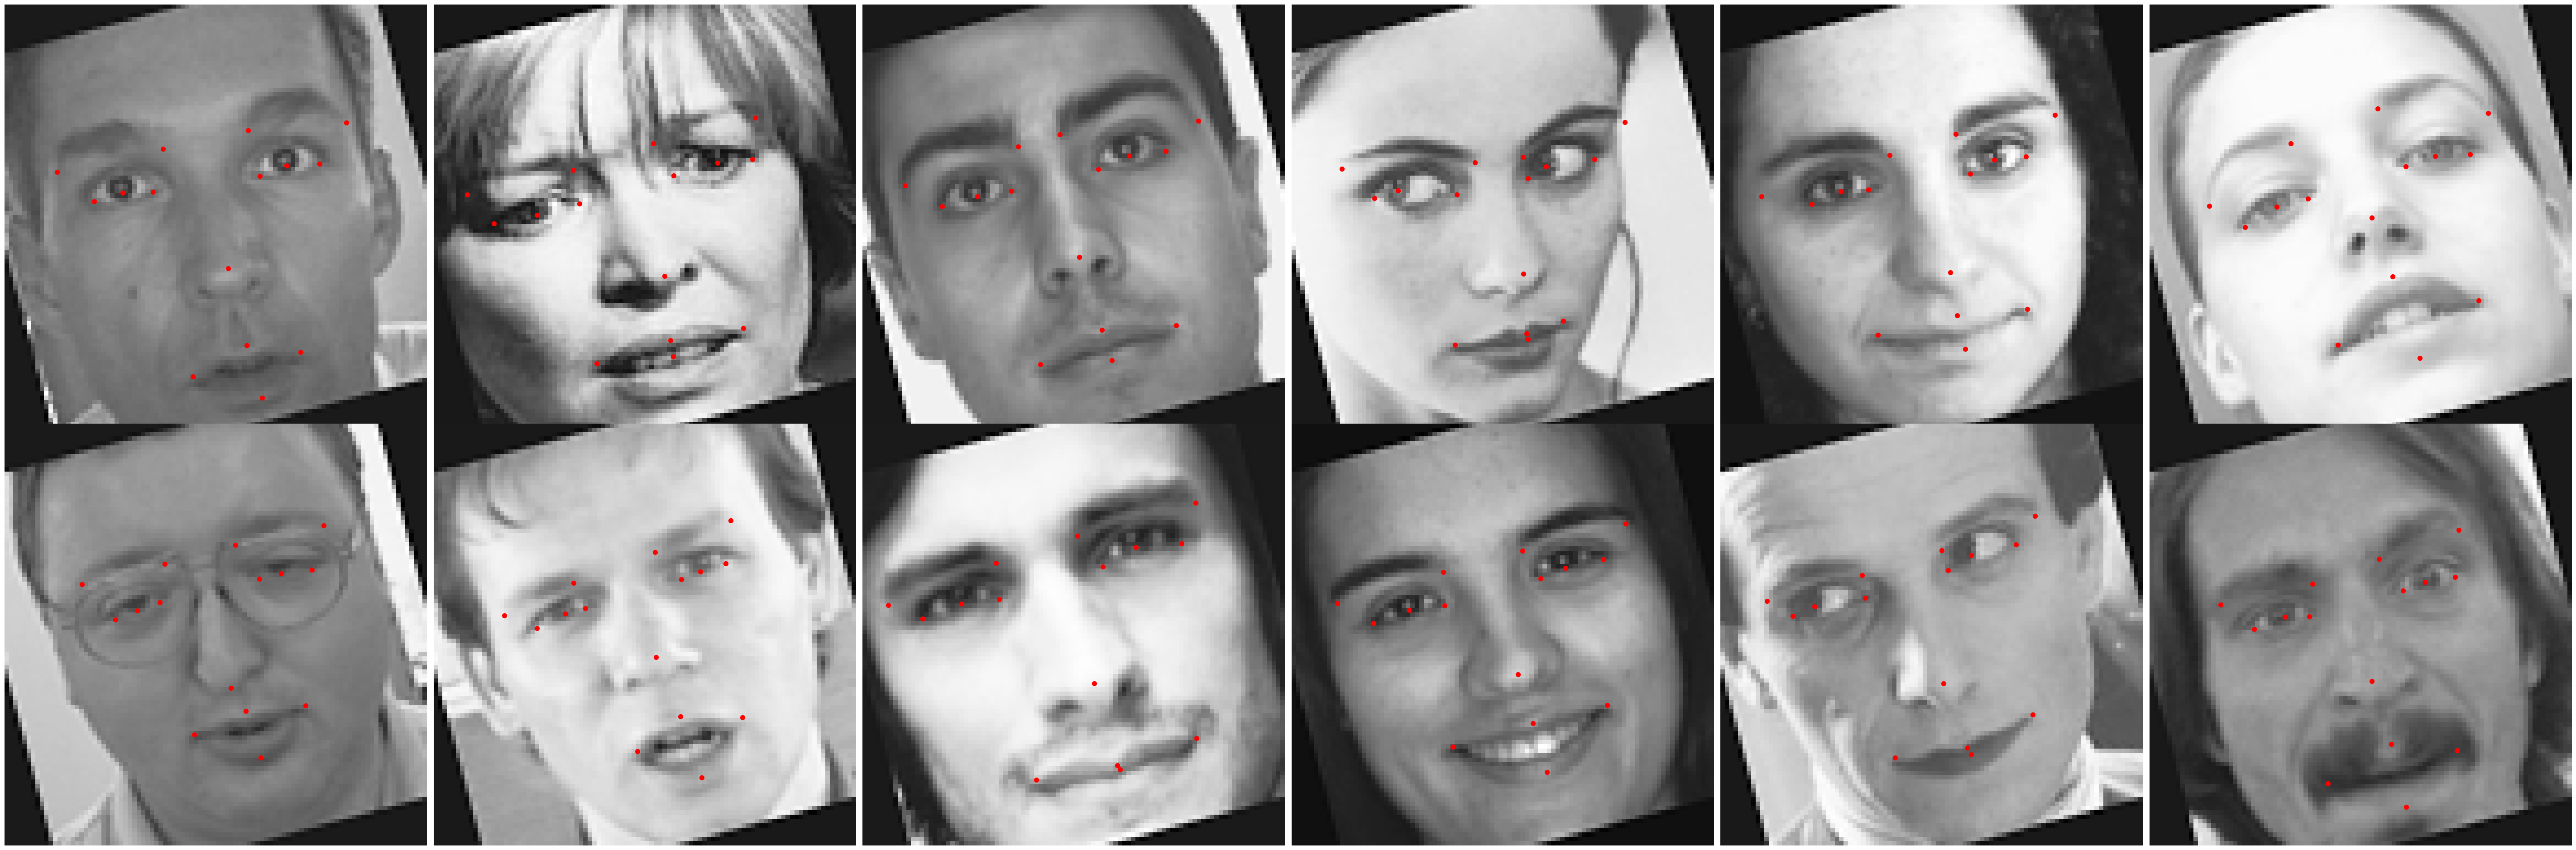

In [36]:
X_rot, y_rot = aug_rotation(trainX,trainY)
print(X_rot.shape)
plot_images(X_rot[:12], y_rot[:12], 6, shrinkage=0.1)

(3189, 96, 96, 1)
Number of rows: 2, number of cols: 6
Figure width: 57, height: 19


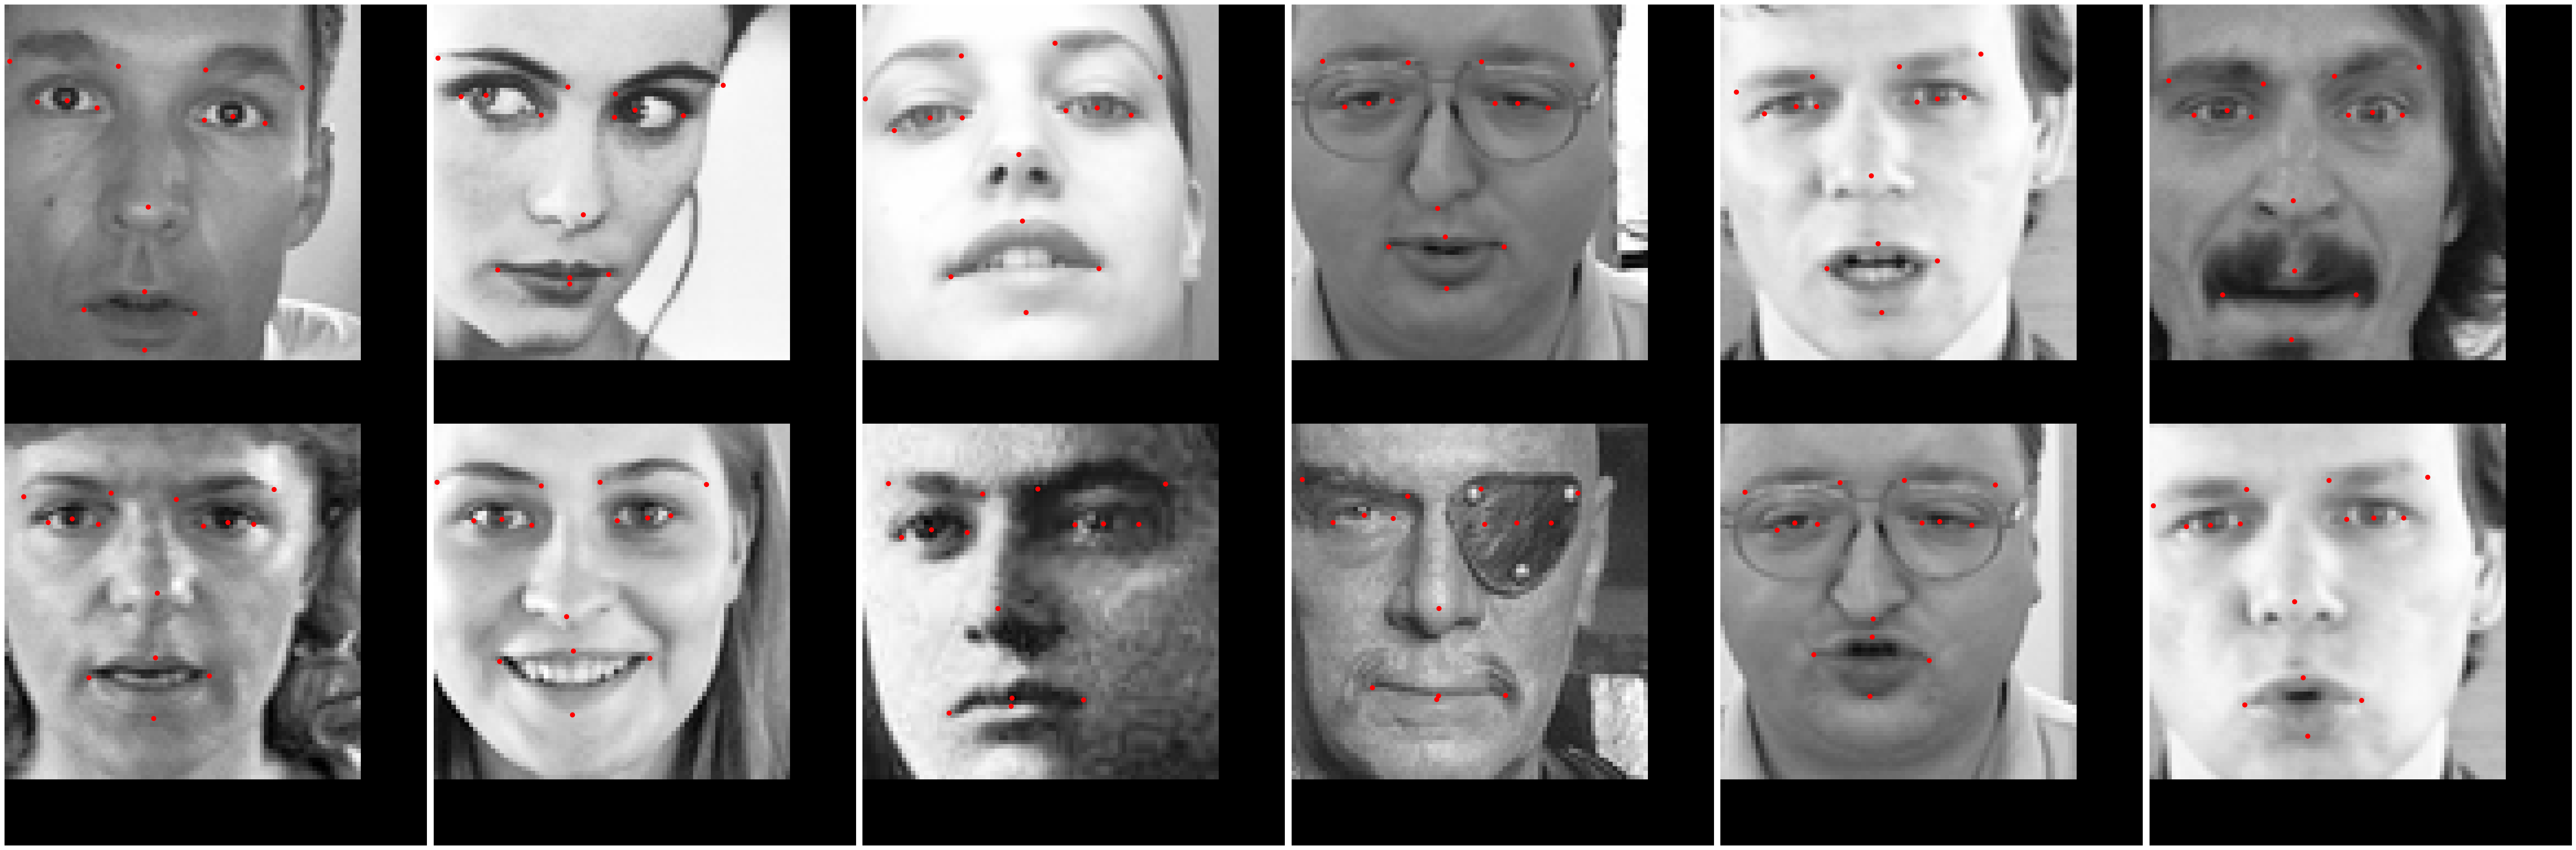

In [37]:
X_shift, y_shift = aug_shift(trainX,trainY)
print(X_shift.shape)
plot_images(X_shift[:12], y_shift[:12], 6, shrinkage=0.1)

(3424, 96, 96, 1)
Number of rows: 2, number of cols: 6
Figure width: 57, height: 19


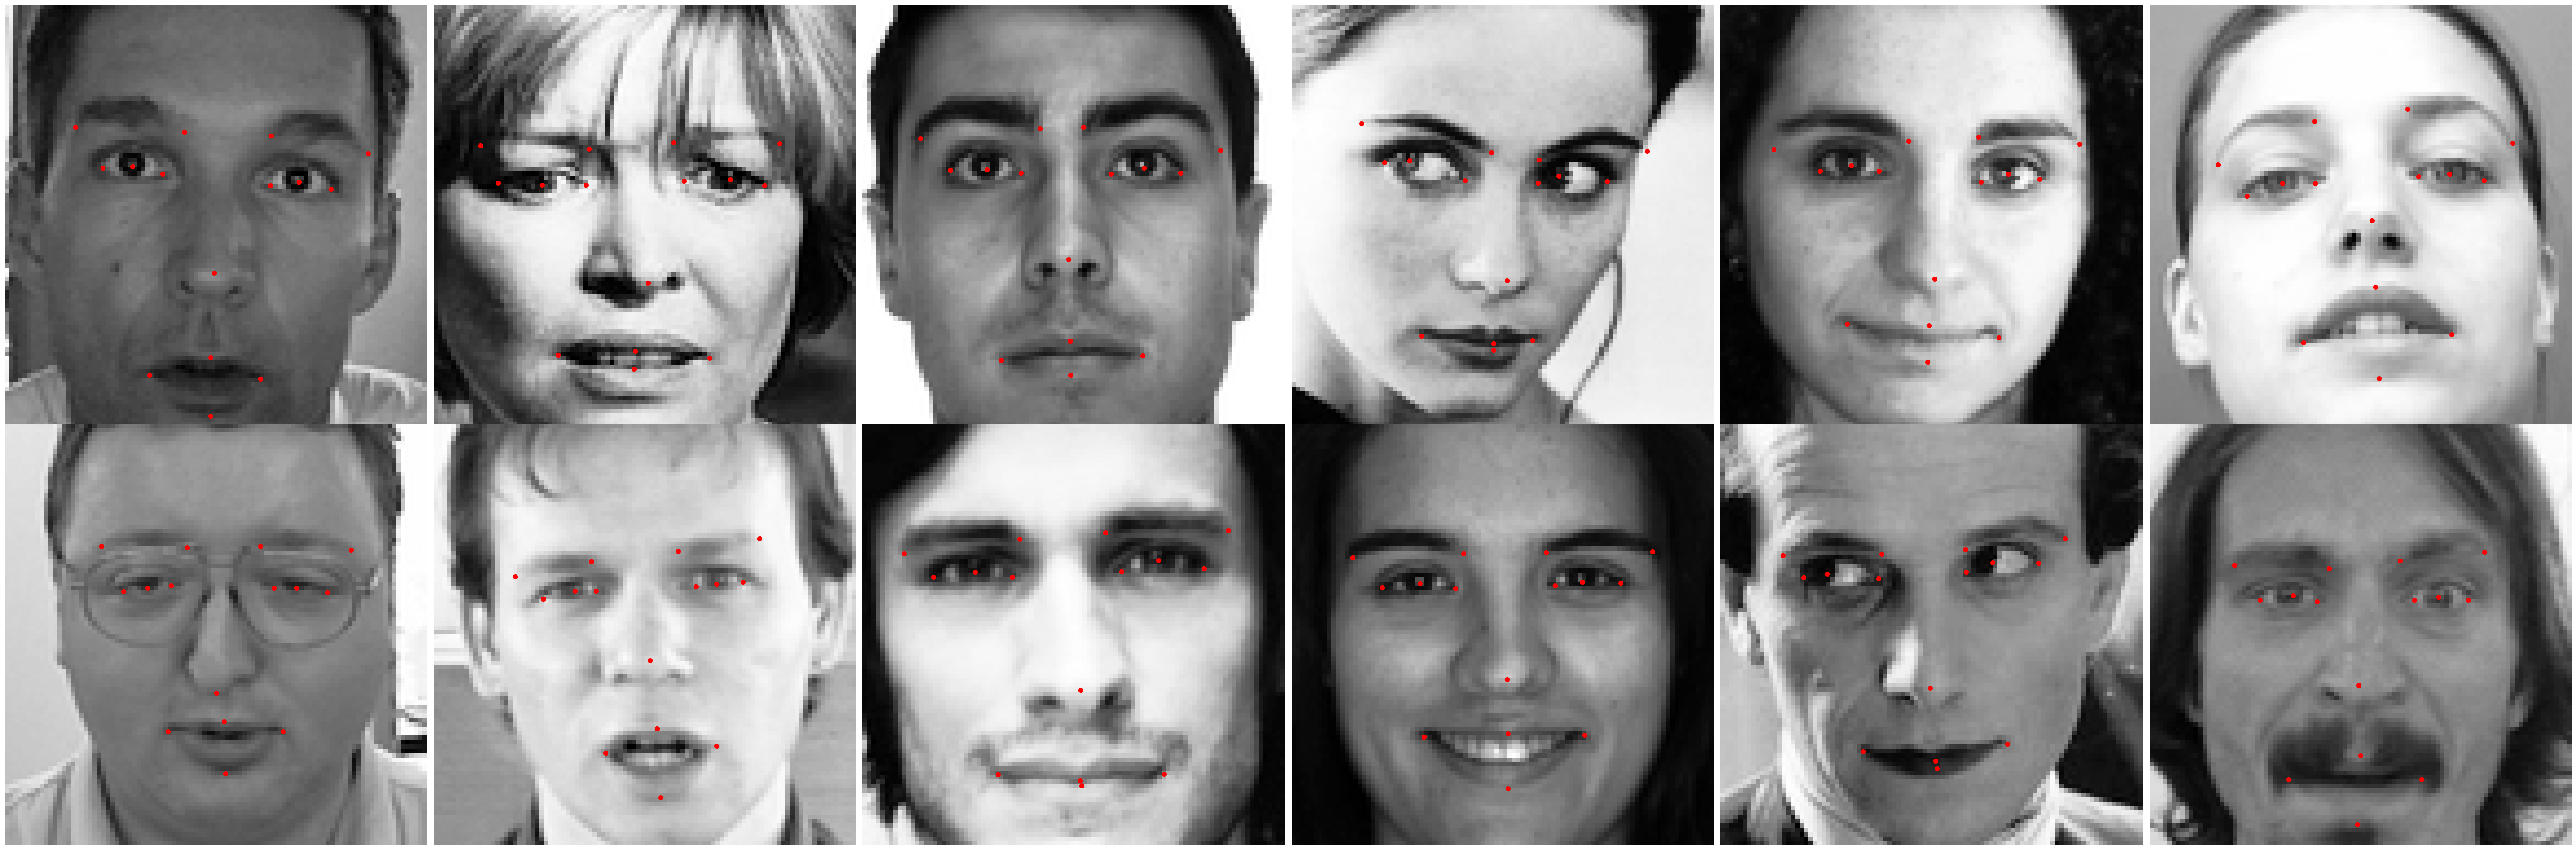

In [38]:
X_brt, y_brt = aug_brightness(trainX,trainY)
print(X_brt.shape)
plot_images(X_brt[:12], y_brt[:12], 6, shrinkage=0.1)

## Generate final augmented training data

In [39]:
# First check all shapes

print(X_brt.shape, y_brt.shape)
print(X_shift.shape, y_shift.shape)
print(X_rot.shape, y_rot.shape)

(3424, 96, 96, 1) (3424, 30)
(3189, 96, 96, 1) (3189, 30)
(3424, 96, 96, 1) (3424, 30)


In [40]:
X = np.concatenate((trainX, X_brt, X_shift, X_rot))
y = np.concatenate((trainY, y_brt, y_shift, y_rot))

print(X.shape, y.shape)
print(X.min(), "----",X.max())
print(y.min(), "----", y.max())

(11749, 96, 96, 1) (11749, 30)
-0.11743486 ---- 1.2
-1.4202186712259675 ---- 97.92002017642149


## Build the model with augmented data

In [41]:
model = tf.keras.Sequential()

# add first convolution layer to the model
model.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))


# add a max pooling layer with pool size (2,2) and strides of 2
# (this will reduce the spatial dimensions by half)
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    name='pool_1'))

# add dropout layer
# model.add(tf.keras.layers.Dropout(
#     rate=0.2))

# add second convolutional layer
model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(2, 2),
    strides=(1, 1),
    padding='same',
    name='conv_2',
    activation='relu'))

# add second max pooling layer with pool size (2,2) and strides of 2
# (this will further reduce the spatial dimensions by half)
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_2')
)

# # add third convolutional layer
# model.add(tf.keras.layers.Conv2D(
#     filters=128,
#     kernel_size=(2, 2),
#     strides=(1, 1),
#     padding='same',
#     name='conv_3',
#     activation='relu'))

# # add second max pooling layer with pool size (2,2) and strides of 2
# # (this will further reduce the spatial dimensions by half)
# model.add(tf.keras.layers.MaxPool2D(
#     pool_size=(2, 2), name='pool_3')
# )

# add a fully connected layer (need to flatten the output of the previous layers first)
model.add(tf.keras.layers.Flatten()) 

# add dropout layer
# model.add(tf.keras.layers.Dropout(
#     rate=0.5))

model.add(tf.keras.layers.Dense(
    units=1024,
    name='fc_1', 
    activation='relu'))

# add dropout layer
model.add(tf.keras.layers.Dropout(
    rate=0.5))

# add the last fully connected layer
# this last layer sets the activation function to "None" in order to output the logits 
# note that passing activation = "sigmoid" will return class memembership probabilities but
# in TensorFlow logits are prefered for numerical stability
# set units=2 to get two output unit (coordinates for one keypoint)
model.add(tf.keras.layers.Dense(
    units=30,
    name='fc_2',
    activation=None))


# build model and print summary
tf.random.set_seed(1)
model.build(input_shape=(None, 96, 96,1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 96, 96, 32)        320       
                                                                 
 pool_1 (MaxPooling2D)       (None, 48, 48, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 48, 48, 64)        8256      
                                                                 
 pool_2 (MaxPooling2D)       (None, 24, 24, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 36864)             0         
                                                                 
 fc_1 (Dense)                (None, 1024)              37749760  
                                                                 
 dropout_1 (Dropout)         (None, 1024)             

# Define callbacks

* Early stopping if no improvement
* Reduce learning rate when a metric has stopped improving.

In [42]:
# Early stopping if no improvement
early_stop = EarlyStopping(monitor = 'loss', 
                           patience = 5, 
                           mode = 'min',
                           baseline=None)

# Reduce learning rate when a metric has stopped improving.
# reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', 
#                               factor = 0.7,
#                               patience = 5, 
#                               min_lr = 1e-15,
#                               mode = 'min', 
#                               verbose = 1)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.MeanSquaredError()) 

## Train model with augmented data

In [43]:

tf.random.set_seed(1234)
np.random.seed(1234)
history = model.fit(X, y,
                    epochs=10, 
                    validation_data=(devX, devY),
                    callbacks=[early_stop]
)

Epoch 1/10
368/368 [==============================] - 98s 264ms/step - loss: 99.1299 - val_loss: 10.7206
Epoch 2/10
368/368 [==============================] - 98s 266ms/step - loss: 25.5284 - val_loss: 17.6527
Epoch 3/10
368/368 [==============================] - 109s 297ms/step - loss: 21.8894 - val_loss: 10.2637
Epoch 4/10
368/368 [==============================] - 107s 290ms/step - loss: 19.8771 - val_loss: 13.4170
Epoch 5/10
368/368 [==============================] - 105s 286ms/step - loss: 18.4371 - val_loss: 6.1384
Epoch 6/10
368/368 [==============================] - 105s 286ms/step - loss: 17.6379 - val_loss: 5.9861
Epoch 7/10
368/368 [==============================] - 105s 286ms/step - loss: 17.6279 - val_loss: 5.6363
Epoch 8/10
368/368 [==============================] - 106s 288ms/step - loss: 16.6502 - val_loss: 5.6487
Epoch 9/10
368/368 [==============================] - 110s 298ms/step - loss: 16.8600 - val_loss: 5.4146
Epoch 10/10
368/368 [==============================] 

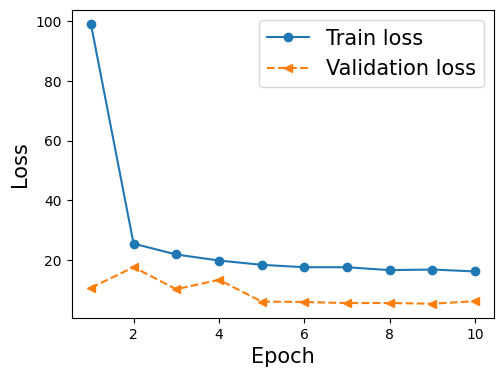

In [44]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

plt.show()

In [45]:
# compare to Kaggle competition benchmark (with validation set)
# RMSE
np.sqrt(14.3482)

3.7879017938695294

In [47]:
 model.predict(devX[:3])

1/1 [==============================] - 0s 152ms/step


array([[66.82717 , 36.36919 , 29.164904, 36.08858 , 60.340504, 37.01897 ,
        73.55646 , 37.199207, 35.657005, 36.764748, 22.28337 , 37.149082,
        56.961807, 28.116972, 80.147026, 29.198917, 38.935345, 27.981148,
        15.067486, 29.69027 , 47.656143, 55.17476 , 62.49278 , 75.562515,
        33.82049 , 75.357925, 47.920143, 69.645935, 47.890236, 83.62815 ],
       [65.10335 , 36.544235, 30.76804 , 38.58449 , 59.08989 , 37.59902 ,
        71.395355, 36.83858 , 36.874268, 38.87353 , 24.295176, 39.99708 ,
        55.814976, 29.544043, 76.785095, 29.10699 , 39.000786, 30.698284,
        17.514894, 33.584923, 48.875645, 54.04973 , 64.10866 , 71.9969  ,
        36.919987, 73.79135 , 49.984097, 67.815704, 50.577225, 79.72696 ],
       [63.904324, 35.49372 , 29.882565, 36.81727 , 57.88603 , 36.426685,
        70.09867 , 35.90115 , 35.904804, 37.245754, 23.451382, 38.0627  ,
        54.72861 , 28.609768, 75.56689 , 28.423454, 38.174618, 29.352057,
        16.82432 , 31.624268, 47.422

In [48]:
devX.shape

(428, 96, 96, 1)

In [50]:
devX[0]*255

array([[[ 52.],
        [ 54.],
        [ 74.],
        ...,
        [254.],
        [254.],
        [254.]],

       [[ 48.],
        [ 55.],
        [ 77.],
        ...,
        [254.],
        [254.],
        [254.]],

       [[ 48.],
        [ 55.],
        [ 81.],
        ...,
        [254.],
        [254.],
        [254.]],

       ...,

       [[156.],
        [155.],
        [157.],
        ...,
        [199.],
        [174.],
        [186.]],

       [[154.],
        [155.],
        [156.],
        ...,
        [192.],
        [176.],
        [182.]],

       [[155.],
        [154.],
        [155.],
        ...,
        [189.],
        [172.],
        [181.]]], dtype=float32)